In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import firwin, freqz, lfilter


import seaborn as sns
sns.set_style("white")

def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

In [2]:
I =1
Q = 0.3
U = 0.5
V = 0.0
cov = np.array([[I+Q,U,0,V],
              [U,I-Q,V,0],
              [0,V,I+Q,U],
              [V,0,U, I-Q]])

In [3]:
modes = np.random.multivariate_normal(np.zeros(4),cov,2**19+1)

In [4]:
sxf = modes[:,0]+1j*modes[:,2]
syf = modes[:,1]+1j*modes[:,3]

In [5]:
sx = np.fft.irfft(sxf)
sy = np.fft.irfft(syf)

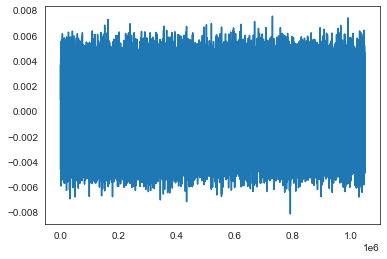

In [6]:
plt.plot(sx)

In [7]:
# Define change in angle here
c = 3e8
A = 30
def faraday_rotation_angle(w):
    if w==0:
        far_angle = 0
    else:
        far_angle = A*c**2/w**2
    
    return far_angle

In [8]:
time = np.linspace(0.0,0.01,len(sx),endpoint=False)
npts = len(time)
k = np.fft.rfftfreq(len(time))
kfreq = k*npts/(max(time)+time[1])  #Frequncies on the axis.

In [9]:
# freqeuncies for faraday rotation
freq =kfreq[1:]*1e2

#### When averaging by changing the shape of the signal. Should It be averaged for every observable we will be looking for? 
#### Should we average and then make the required transformations or usage in functions or the other way around?

In [10]:
Fx = np.fft.rfft(sx)
Fy = np.fft.rfft(sy)


In [11]:
def rebin (freq):
    
    
### now let's double the bins as we need them
# we have min bin width is
# dx = < pi x**3/2A
# needed bin width multiplier is this
    df = freq[1]-freq[0]
    print(df)
    A = 30
    need_dx = np.pi/2*freq**3/(2*A*c**2)
    mult = need_dx / df
    #print(mult)
## now round to power of two
#print(len(mult))
    mult = (np.log(mult)/np.log(2)).astype(int)+1
#print(len(mult))
#print(mult)

    mult[mult<0]=0
    mult = (2**mult)*16
    #print(mult)
    return mult



In [12]:
def Aver (sig,fr):
    signew = [];
    frnew = [];
    j = 0
    mult = rebin(fr)
    #print("siglen",len(sig))
    for i in mult:
        
    
        if j>len(sig):
            count = i-(j-len(sig))
            j=j-i
            #print(count)
            #print(j)
            signew = np.append(signew,sum(sig[j:j+count-1])/count)
            frnew = np.append(frnew,fr[j+count-2])
            #print(count)
            break
        if j<len(sig):
            signew = np.append(signew,sum(sig[j:j+i])/i)
            frnew = np.append(frnew,fr[j-1])
        j = j+i
    return signew

In [13]:
def PS (fr,a,b=None):
    if b is None:
        prod = np.real(a*np.conj(a))
    else:
        prod = a*np.conj(b)
    #print("prod",prod.shape)
    binPk = Aver(prod,fr) 
    #binPk = prod[1:].reshape((2**8,-1)).mean(axis=-1)
    
    
    return binPk

#### Finding the freqeuncy axis after averaging/rebinning.


In [14]:
def avefr (fr):
    frnew = [];
    j = 0
    mult = rebin(fr)
    for i in mult:
        
    
        if j>len(fr)+1:
            count = i-(j-len(fr))
            j=j-i
            #print(count)
            #print(j)
            
            frnew = np.append(frnew,fr[j+count-2])
            #print(count)
            break
        if j<len(fr):
           
            frnew = np.append(frnew,fr[j])
        j = j+i
    return frnew
    

In [15]:
freq_new = avefr(freq)

10000.0


In [16]:
len(freq_new)

7264

In [17]:
Pxx = PS(freq,Fx)
Pyy = PS(freq,Fy)
Pxy = PS(freq,Fx,Fy)
Pyx = PS(freq,Fy,Fx)
I = Pxx+Pyy
Q = Pxx-Pyy
U = np.real(Pxy+Pyx)    # from wikipedia
V = np.imag(Pxy-Pyx)
N = np.mean(I)
I/=N
Q/=N
U/=N
V/=N
#len(Pxx[0])

10000.0
10000.0
10000.0
10000.0


In [18]:
len(I)

7265

In [19]:
print(I**2)

[8.98933132e-01 7.58524607e-01 1.57269151e+00 ... 1.00572887e+00
 3.05025061e-08 0.00000000e+00]


In [20]:
print(Q**2+U**2+V**2)

[4.27547704e-01 3.14303541e-01 4.72075852e-01 ... 3.27868050e-01
 3.05025061e-08 0.00000000e+00]


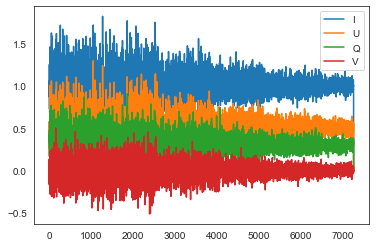

In [21]:
plt.plot(I,label="I")
plt.plot(U,label="U")
plt.plot(Q,label="Q")
plt.plot(V,label="V")
plt.legend()


In [22]:
len(sx)/2

524288.0

In [23]:
#time = np.linspace(0.0,0.01,len(sx),endpoint=False)
#npts = len(time)

In [24]:
#k = np.fft.rfftfreq(len(time))
#kfreq = k*npts/(max(time)+time[1])  #Frequncies on the axis.

In [25]:
len(kfreq)

524289

###### Showing the difference between two frequencies on the freq axis.

In [26]:
kfreq[3]-kfreq[2]

100.0

In [27]:
#print(kfreq)

In [28]:
#plt.plot(kfreq,Fx)

In [29]:
#max(kfreq)

In [30]:
#len(Fx[1:])

In [31]:
Fx1 = Fx.copy()    ## Making the copies so that I don't alter the original signal by mistake
Fy1 = Fy.copy()
Fx2 = Fx.copy()
Fy2 = Fy.copy()

### Defining the faraday rotation angle

In [32]:

far_rot = np.zeros(len(kfreq[1:]))
for i in range(len(freq)):
    far_rot[i] = faraday_rotation_angle(freq[i])
    Fx2[i] = Fx1[i]*np.cos(far_rot[i]/2)+Fy1[i]*np.sin(far_rot[i]/2)
    Fy2[i] = -Fx1[i]*np.sin(far_rot[i]/2)+Fy1[i]*np.cos(far_rot[i]/2)
    
## Fx2 and Fy2 are the final signals in fourier space after faraday rotation

In [33]:
#len(freq)

In [34]:
#print(freq)

In [35]:
sx1 = np.fft.irfft(Fx2)
sy1 = np.fft.irfft(Fy2)
len(sx1)
## sx1 and sy1 are signals in time space after faraday rotation with 

1048576

In [36]:
#print(freq)

In [37]:
#len(freq)

In [38]:
#len(far_rot)

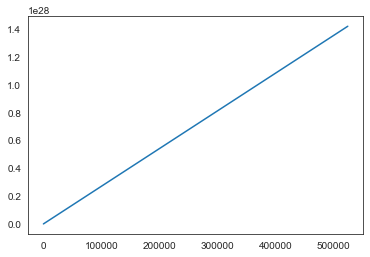

In [39]:
plt.plot(freq**3*far_rot)
#plt.semilogx()

####  Stokes parameters after Far. rotation

In [40]:
Pxx1 = PS(freq,Fx2)
Pyy1 = PS(freq,Fy2)
Pxy1 = PS(freq,Fx2,Fy2)
Pyx1 = PS(freq,Fy2,Fx2)
I1 = Pxx1+Pyy1
Q1 = Pxx1-Pyy1
U1 = np.real(Pxy1+Pyx1)
V1 = np.imag(Pxy1-Pyx1)
N1 = np.mean(I1)
I1/=N1
Q1/=N1
U1/=N1
V1/=N1

10000.0
10000.0
10000.0
10000.0


In [41]:
f = np.arange(len(I1))+1

In [42]:
len(f)

7265

In [43]:
print(f)

[   1    2    3 ... 7263 7264 7265]


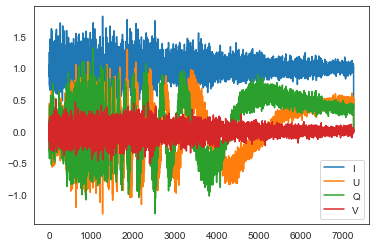

In [44]:
plt.plot(I1,label="I")
plt.plot(U1,label="U")
plt.plot(Q1,label="Q")
plt.plot(V1,label="V")
plt.legend()


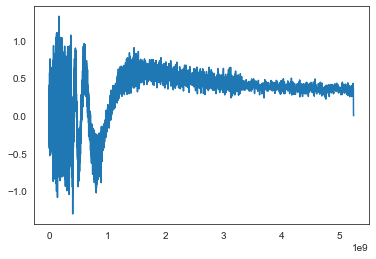

In [45]:
plt.plot(freq_new,Q1[1:])

(0.0, 3e-16)

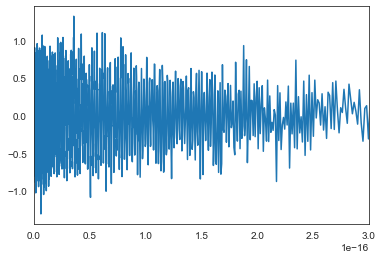

In [46]:
plt.plot(1/freq_new**2,Q1[1:])
plt.xlim(0,0.3e-15)

In [76]:
f = np.arange(len(Q1))+1

(0.0, 5e-05)

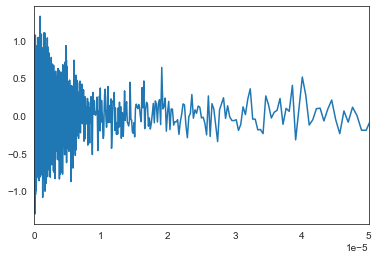

In [86]:
plt.plot(1/f**2,Q1)
plt.xlim(0,5e-5)

#### The U and Q are the ones that are varied during faraday rotation and they have changed a lot compared to their respective values before rotation

### IN the four cells below this, I'm trying to see if by averaging before would it make any sense. I was following your lead on length of 32, maybe this can be changed.

## Was just trying out stuff like understanding the averaging in python array. NOthing important

In [47]:
#binPks = sx1.reshape((2**5,-1)).mean(axis=-1)

In [48]:
#binPkfre = kfreq[1:len(kfreq)].reshape((2**5,-1)).mean(axis=-1)

In [49]:
#far_rot2 = far_rot[len(far_rot)-1].reshape((2**5,-1)).mean(axis=-1)
#for i in range(len(binPkfre)):
    
 #   far_rot2[i] = faraday_rotation_angle(binPkfre[i])

In [50]:
#plt.semilogx(binPkfre,far_rot2)

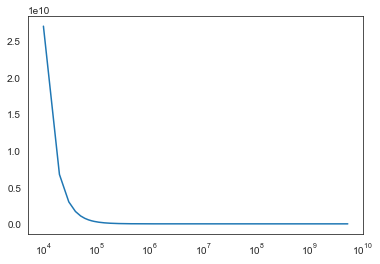

In [51]:
plt.semilogx(freq,far_rot)

## The PFB part starts here, for a start I was using the basic code that was written in the PFB introductory jupyter notebook https://github.com/telegraphic/pfb_introduction and trying to see if I can include our data into that basic code. 


In [52]:
def pfb_fir_frontend(x, win_coeffs, M, P):
    W = int(x.shape[0] / M / P)
    x_p = x.reshape((W*M, P)).T
    h_p = win_coeffs.reshape((M, P)).T
    x_summed = np.zeros((P, M * W - M))
    for t in range(0, M*W-M):
        x_weighted = x_p[:, t:t+M] * h_p
        x_summed[:, t] = x_weighted.sum(axis=1)
    return x_summed.T

In [53]:
def generate_win_coeffs(M, P, window_fn="hamming"):
    win_coeffs = scipy.signal.get_window(window_fn, M*P)
    sinc       = scipy.signal.firwin(M * P, cutoff=1.0/P, window="rectangular")
    win_coeffs *= sinc
    return win_coeffs

In [54]:
def fft(x_p, P, axis=1):
    return np.fft.rfft(x_p, P, axis=axis),np.fft.rfftfreq(int(P),d=1./10**6)

def pfb_filterbank(x, win_coeffs, M, P):
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    return x_pfb

#### In the code below where its commented, trimming of the array. I didn't do that because, it was removing some data from the set in the original PFB sample code which we don't want. Hence I commented it out.

In [55]:
def pfb_spectrometer(x,y, n_taps, n_chan, n_int, window_fn="hamming"):
    M = n_taps
    P = n_chan
    
    # Generate window coefficients
    win_coeffs = generate_win_coeffs(M, P, window_fn)
    plt.plot(win_coeffs)
    plt.title("Window coefficients the sinc function")
    plt.show()

    # Apply frontend, take FFT, then take power (i.e. square)
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    print("xfir",x_fir.shape)
    x_pfb,x_freq = fft(x_fir, P)
    print("x_pfb",x_pfb.shape)
    #x_freq = 
    #k = np.fft.rfftfreq(len(time))
    #k_freq = x_freq*npts/(max(x_pfb)+x_pfb[1])
    y_fir = pfb_fir_frontend(y, win_coeffs, M, P)
    y_pfb,y_freq = fft(y_fir, P)
    print("yfreq",len(y_freq))
    x_psd = np.abs(x_pfb)**2
    y_psd = np.abs(y_pfb)**2
    xy_psd = x_pfb*np.conj(y_pfb)
    yx_psd = y_pfb*np.conj(x_pfb)
    
    
    rxy_psd = np.real(xy_psd+yx_psd)
    imxy_psd = np.imag(xy_psd-yx_psd)
    
    
    
    # Trim array so we can do time integration
    #x_psd = x_psd[:np.round(x_psd.shape[0]//n_int)*n_int]
    #print(x_psd.shape)
    #y_psd = y_psd[:np.round(y_psd.shape[0]//n_int)*n_int]
    #rxy_psd = rxy_psd[:np.round(rxy_psd.shape[0]//n_int)*n_int]
    #imxy_psd = imxy_psd[:np.round(imxy_psd.shape[0]//n_int)*n_int]

    # Integrate over time, by reshaping and summing over axis (efficient)
    x_psd = x_psd.reshape(x_psd.shape[0]//n_int, n_int, x_psd.shape[1])
    #print(x_psd.shape)
    y_psd = y_psd.reshape(y_psd.shape[0]//n_int, n_int, y_psd.shape[1])
    rxy_psd = rxy_psd.reshape(rxy_psd.shape[0]//n_int, n_int, rxy_psd.shape[1])
    imxy_psd = imxy_psd.reshape(imxy_psd.shape[0]//n_int, n_int, imxy_psd.shape[1])
    
    
    x_psd = x_psd.mean(axis=1)
    #print(x_psd.shape)
    y_psd = y_psd.mean(axis=1)
    rxy_psd = rxy_psd.mean(axis=1)
    imxy_psd = imxy_psd.mean(axis=1)
    

    
    return x_psd,y_psd,rxy_psd,imxy_psd,x_freq

#### THe values are chosen such that the M*P*W gives us the number of elements in the main signal array. Which in our original case is 8192. THe value of P is chosen to have 128 finals bins(Same number of bins as the averaging for the source stokes parameters in Cell [9]

In [56]:
datax = sx1
datay = sy1
M = 8
P = 2**9
W = 2**8

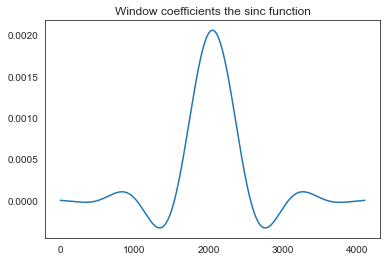

xfir (2040, 512)
x_pfb (2040, 257)
yfreq 257
257


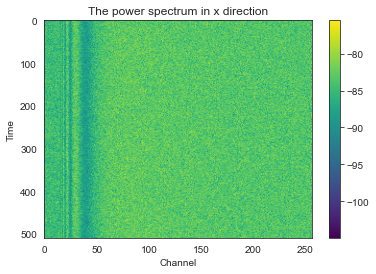

In [57]:
X_psd,Y_psd,RXY_psd,IMXY_psd,X_freq = pfb_spectrometer(datax, datay, n_taps=M, n_chan=P, n_int=4, window_fn="hamming")
#print(len(X_psd))
#print(len(Y_psd))
#print(len(RXY_psd))
#print(len(IMXY_psd))
print(len(X_freq))
plt.imshow(db(X_psd), cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel("Channel")
plt.ylabel("Time")
plt.title("The power spectrum in x direction")
plt.show()


#### The below 4-5 cells are just for understanding how the averaging works in python. Can we commented out which I did.

In [58]:
#Y_psd.shape

In [59]:
print(X_freq)

[     0.      1953.125   3906.25    5859.375   7812.5     9765.625
  11718.75   13671.875  15625.     17578.125  19531.25   21484.375
  23437.5    25390.625  27343.75   29296.875  31250.     33203.125
  35156.25   37109.375  39062.5    41015.625  42968.75   44921.875
  46875.     48828.125  50781.25   52734.375  54687.5    56640.625
  58593.75   60546.875  62500.     64453.125  66406.25   68359.375
  70312.5    72265.625  74218.75   76171.875  78125.     80078.125
  82031.25   83984.375  85937.5    87890.625  89843.75   91796.875
  93750.     95703.125  97656.25   99609.375 101562.5   103515.625
 105468.75  107421.875 109375.    111328.125 113281.25  115234.375
 117187.5   119140.625 121093.75  123046.875 125000.    126953.125
 128906.25  130859.375 132812.5   134765.625 136718.75  138671.875
 140625.    142578.125 144531.25  146484.375 148437.5   150390.625
 152343.75  154296.875 156250.    158203.125 160156.25  162109.375
 164062.5   166015.625 167968.75  169921.875 171875.    173828

In [60]:
f = X_freq[1:]
len(f)

256

In [61]:
#X_psd[:,:-1].shape

In [62]:
#Y = Y_psd[:,:-1].reshape((32,-1))

In [63]:
#Y.shape

In [64]:
#print(IMXY_psd)

In [65]:
X_psd = X_psd[:,1:].mean(axis=0)
Y_psd = Y_psd[:,1:].mean(axis=0)
RXY_psd = RXY_psd[:,1:].mean(axis=0)
IMXY_psd = IMXY_psd[:,1:].mean(axis=0)

print(X_psd.shape)
print(Y_psd.shape)
print(RXY_psd.shape)
print(IMXY_psd.shape)


I2 = X_psd+Y_psd
Q2 = X_psd-Y_psd
U2 = RXY_psd
V2 = -IMXY_psd
N2 = np.mean(I2)
I2/=N2
Q2/=N2
U2/=N2
V2/=N2


(256,)
(256,)
(256,)
(256,)


In [66]:
#print(I2**2)

In [67]:
#print(Q2**2+U2**2+V2**2)

In [68]:
#np.shape(X_psd)

In [69]:
#print(U2)

In [70]:
#print(U1)

In [71]:
#print(V2)

In [72]:
len(I2)

256

Text(0.5, 1.0, 'Stokes parameters of Faraday rotated signal using PFB')

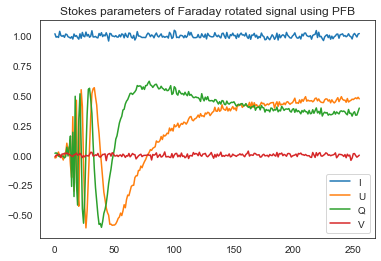

In [73]:
plt.plot(I2,label="I")
plt.plot(U2,label="U")
plt.plot(Q2,label="Q")
plt.plot(V2,label="V")
plt.legend()
plt.title("Stokes parameters of Faraday rotated signal using PFB")

ValueError: x and y must have same first dimension, but have shapes (524288,) and (7264,)

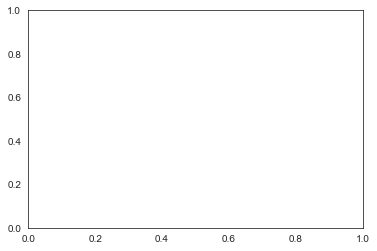

In [74]:
plt.plot(1/freq**2,Q1[1:])
plt.xlim(0,0.02e-8)

In [ ]:
plt.plot(1/f**2,Q2)
plt.xlim(0,0.5e-8)

In [ ]:
plt.plot(I1,label="I")
plt.plot(U1,label="U")
plt.plot(Q1,label="Q")
plt.plot(V1,label="V")
plt.legend()
plt.title("Stokes Parameters of Faraday rotated signal using Faraday rotation formula")

In [ ]:
plt.plot(I,label="I")
plt.plot(U,label="U")
plt.plot(Q,label="Q")
plt.plot(V,label="V")
plt.legend()
plt.title("Original signal at the source")

### By looking at the above plots, the plots generated by the PFB and the one generated normally using the Faraday rotation formula look similar. Further changes can be made to make it more better such as increasing the bins as per frequency. The lower the frequency, the more number of bins so as not to destroy the faraday rotation because of the averaging.?

In [ ]:
#len(freq)

In [ ]:
#df = freq[1]-freq[0]
#print(df)
#A = 30

In [ ]:
### now let's double the bins as we need them
# we have min bin width is
# dx = < pi x**3/2A
# needed bin width multiplier is this
#need_dx = np.pi/2*freq**3/(2*A*c**2)
#mult = need_dx / df
#print(mult)
## now round to power of two
#print(len(mult))
#mult = (np.log(mult)/np.log(2)).astype(int)+1
#print(len(mult))
#print(mult)

#mult[mult<0]=0
#mult = (2**mult)*16
#print(mult)

In [ ]:
#new_mult = mult[0]*1/mult

In [ ]:
#print(new_mult)

In [ ]:
#new_fr = np.hstack([])

### What to do about the extra data that will  be lost If i truncate in between?


In [ ]:
#count = np.count_nonzero(mult == 1)
#print(count)

In [ ]:
#len(mult)-count

In [ ]:
#mult[1000]

In [ ]:
#len(Q1)-sum(mult[0:14855])

In [ ]:
#mult[14855]

In [ ]:
#len(Q1)

In [ ]:
#plt.plot(freq,Q1)

In [ ]:
#Qnew = [];
#frnew = [];
#j = 0
#for i in mult:
    
 #   if j>len(Q1):
  #      count = i-(j-len(Q1))
   #     j=j-i
    #    print(j)
     #   Qnew = np.append(Qnew,sum(Q1[j:j+count-1])/count)
      #  frnew = np.append(frnew,freq[j+count-2])
       # print(count)
       # break
    #if j<len(Q1):
     #   Qnew = np.append(Qnew,sum(Q1[j:j+i])/i)
      #  frnew = np.append(frnew,freq[j-1])
    #j = j+i
    
   
    

In [ ]:
#Qnew = Qnew/N1

In [ ]:
#plt.plot(Qnew)

In [ ]:
#len(Qnew)

In [ ]:
#len(frnew)

In [ ]:
#plt.plot(1/(np.arange(len(Qnew))+1)**2,Qnew)
#plt.xlim(0,0.15e-5)

In [ ]:
#
#print(Qnew)

In [ ]:
#plt.plot(1/(np.arange(len(Qnew))+1)**2,Qnew)
#plt.xlim(0,0.000003)

In [ ]:
#z = np.array([1,2,3,4,5])

In [ ]:
#z = np.append(z,4)

In [ ]:
#len(z)

In [ ]:
#print(z)